In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def create_exogenous_sequences(X, y, look_back=24):
    Xs, Ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        Ys.append(y[i + look_back])
    return np.array(Xs), np.array(Ys)

df = pd.read_csv("Clean_file.csv")
df["time"] = pd.to_datetime(df["time"])

df["hour"] = df["time"].dt.hour
df["doy"]  = df["time"].dt.dayofyear

df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
df["doy_sin"]  = np.sin(2*np.pi*df["doy"]/365)
df["doy_cos"]  = np.cos(2*np.pi*df["doy"]/365)

df = df.drop(columns=["time", "hour", "doy"])

df["gti"] = df["gti"].clip(lower=0)
df["gti_log"] = np.log1p(df["gti"])
df = df.drop(columns=["gti"])

df = df.replace([np.inf, -np.inf], np.nan).ffill().bfill()

target_col = "P_norm"
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df[[target_col]]).flatten()

feature_cols = [
    "temp_F",
    "gti_log",
    "hour_sin",
    "hour_cos",
    "doy_sin",
    "doy_cos"
]

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[feature_cols])


train_size = int(len(X_scaled) * 0.75)

X_train = X_scaled[:train_size]
y_train = y_scaled[:train_size]

X_test  = X_scaled[train_size:]
y_test  = y_scaled[train_size:]

look_back = 24

trainX, trainY = create_exogenous_sequences(
    X_train, y_train, look_back
)

testX, testY = create_exogenous_sequences(
    X_test, y_test, look_back
)

# Model
model = Sequential([
    LSTM(64, return_sequences=True,
         input_shape=(look_back, X_scaled.shape[1])),
    LSTM(32),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.Huber(delta=0.1),
    metrics=["mae"]
)

model.summary()

history = model.fit(
    trainX, trainY,
    epochs=50,
    batch_size=32,
    validation_data=(testX, testY),
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 24, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,681 (123.75 KB)

 Trainable params: 31,681 (123.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
400/400 - 15s - 38ms/step - loss: 0.0037 - mae: 0.0574 - val_loss: 0.0026 - val_mae: 0.0427
Epoch 2/50
400/400 - 11s - 28ms/step - loss: 0.0024 - mae: 0.0395 - val_loss: 0.0024 - val_mae: 0.0370
Epoch 3/50
400/400 - 10s - 26ms/step - loss: 0.0022 - mae: 0.0349 - val_loss: 0.0022 - val_mae: 0.0341
Epoch 4/50
400/400 - 10s - 25ms/step - loss: 0.0019 - mae: 0.0317 - val_loss: 0.0018 - val_mae: 0.0327
Epoch 5/50
400/400 - 9s - 22ms/step - loss: 0.0017 - mae: 0.0294 - val_loss: 0.0017 - val_mae: 0.0309
Epoch 6/50
400/400 - 10s - 26ms/step - loss: 0.0016 - mae: 0.0271 - val_loss: 0.0016 - val_mae: 0.0271
Epoch 7/50
400/400 - 10s - 26ms/step - loss: 0.0014 - mae: 0.0253 - val_loss: 0.0015 - val_mae: 0.0254
Epoch 8/50
400/400 - 10s - 25ms/step - loss: 0.0014 - mae: 0.0246 - val_loss: 0.0014 - val_mae: 0.0264
Epoch 9/50
400/400 - 9s - 22ms/step - loss: 0.0014 - mae: 0.0242 - val_loss: 0.0014 - val_mae: 0.0261
Epoch 10/50
400/400 - 10s - 26ms/step - loss: 0.0013 - mae: 0.0238 - val_lo

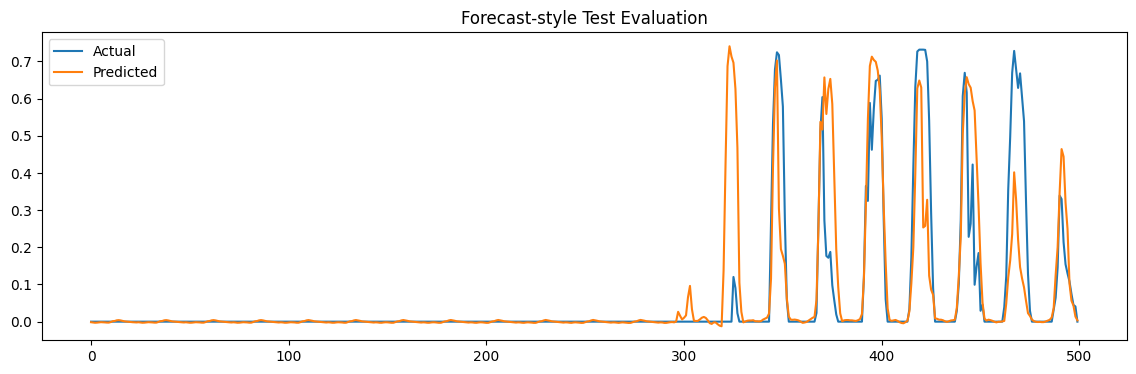

In [ ]:
# Predict test set
y_test_pred_scaled = model.predict(testX, verbose=0)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

y_test_true = scaler_y.inverse_transform(
    y_test.reshape(-1,1)
)

plt.figure(figsize=(14,4))
plt.plot(y_test_true[:500], label="Actual")
plt.plot(y_test_pred[:500], label="Predicted")
plt.legend()
plt.title("Forecast-style Test Evaluation")
plt.show()

Final Train Huber: 0.0010560244554653764
Final Val   Huber: 0.0013188670855015516
Final Train MAE  : 0.02004742994904518
Final Val   MAE  : 0.02329833246767521


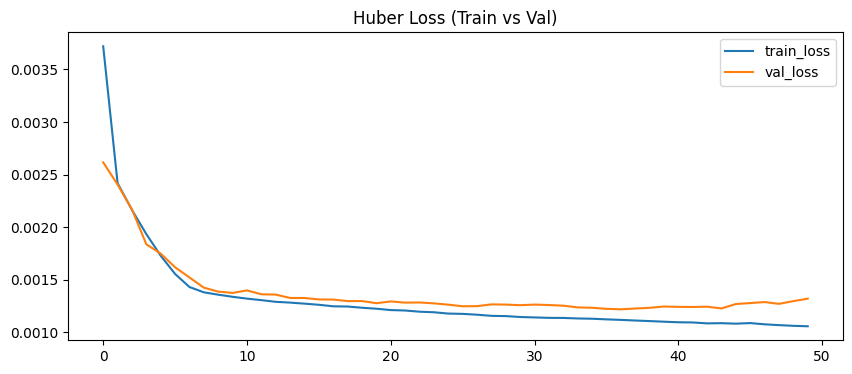

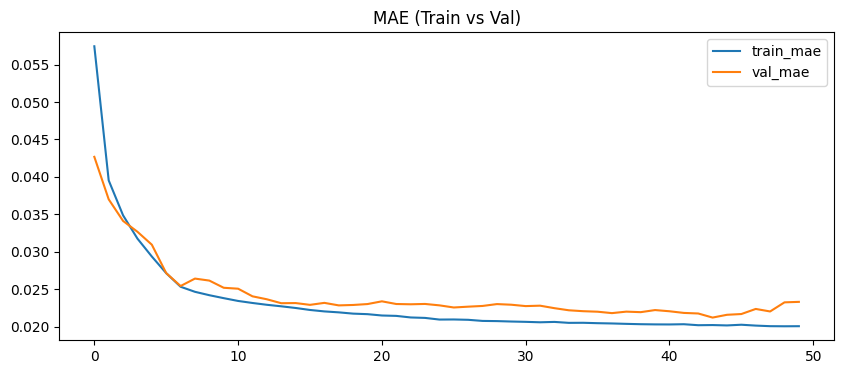

In [ ]:
#METRICS (after training)
print("Final Train Huber:", history.history["loss"][-1])
print("Final Val   Huber:", history.history["val_loss"][-1])
print("Final Train MAE  :", history.history["mae"][-1])
print("Final Val   MAE  :", history.history["val_mae"][-1])

plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Huber Loss (Train vs Val)")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history["mae"], label="train_mae")
plt.plot(history.history["val_mae"], label="val_mae")
plt.legend()
plt.title("MAE (Train vs Val)")
plt.show()


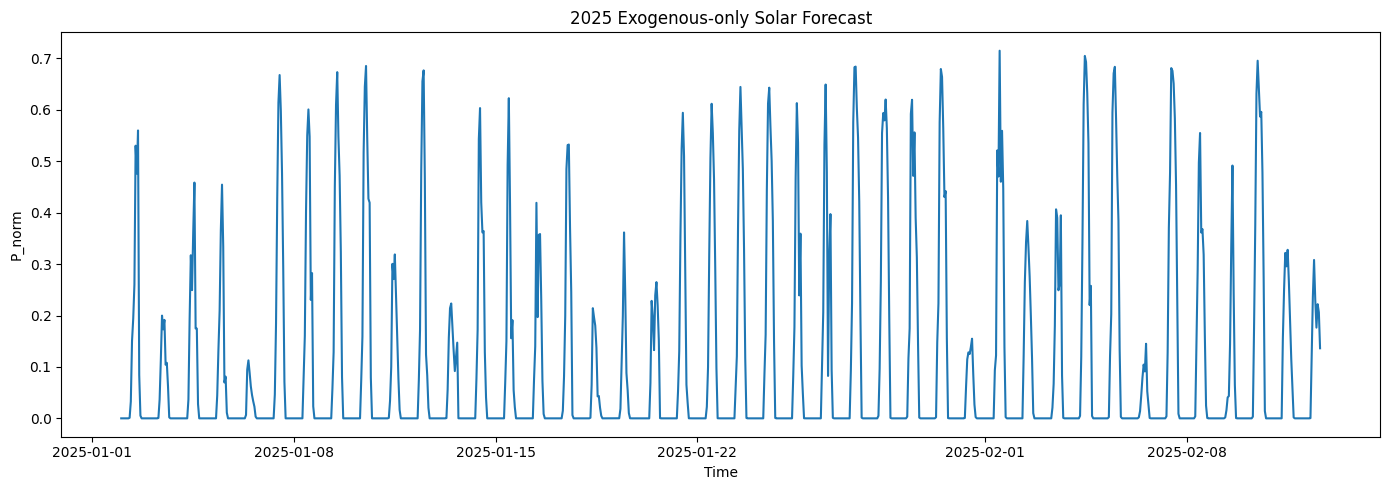

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_f = pd.read_csv("Data_2025_seasonal_filled.csv")
df_f["time"] = pd.to_datetime(df_f["time"])

df_f["gti_raw"] = df_f["gti"].clip(lower=0)

df_f["hour"] = df_f["time"].dt.hour
df_f["doy"]  = df_f["time"].dt.dayofyear

df_f["hour_sin"] = np.sin(2*np.pi*df_f["hour"]/24)
df_f["hour_cos"] = np.cos(2*np.pi*df_f["hour"]/24)
df_f["doy_sin"]  = np.sin(2*np.pi*df_f["doy"]/365)
df_f["doy_cos"]  = np.cos(2*np.pi*df_f["doy"]/365)

df_f = df_f.drop(columns=["hour", "doy"])

df_f["gti_log"] = np.log1p(df_f["gti_raw"])
df_f = df_f.replace([np.inf, -np.inf], np.nan).ffill().bfill()

X_2025 = scaler_X.transform(df_f[feature_cols])

X_2025_seq, _ = create_exogenous_sequences(
    X_2025,
    np.zeros(len(X_2025)),
    look_back
)

# Predict
P_scaled = model.predict(X_2025_seq, verbose=0)
P_norm_pred = scaler_y.inverse_transform(P_scaled).flatten()

# Soft night physics
gti = df_f["gti_raw"].iloc[look_back:].values
night_scale = np.clip(gti / 25.0, 0, 1)
P_norm_pred *= night_scale

P_norm_pred = np.clip(P_norm_pred, 0, 1)

df_out = pd.DataFrame({
    "time": df_f["time"].iloc[look_back:].values,
    "temp_F": df_f["temp_F"].iloc[look_back:].values,
    "gti": gti,
    "P_norm_pred": P_norm_pred
})

df_out.to_csv("2025_forecast_correct.csv", index=False)

plt.figure(figsize=(14,5))
plt.plot(df_out["time"][:1000], df_out["P_norm_pred"][:1000])
plt.title("2025 Exogenous-only Solar Forecast")
plt.xlabel("Time")
plt.ylabel("P_norm")
plt.tight_layout()
plt.show()


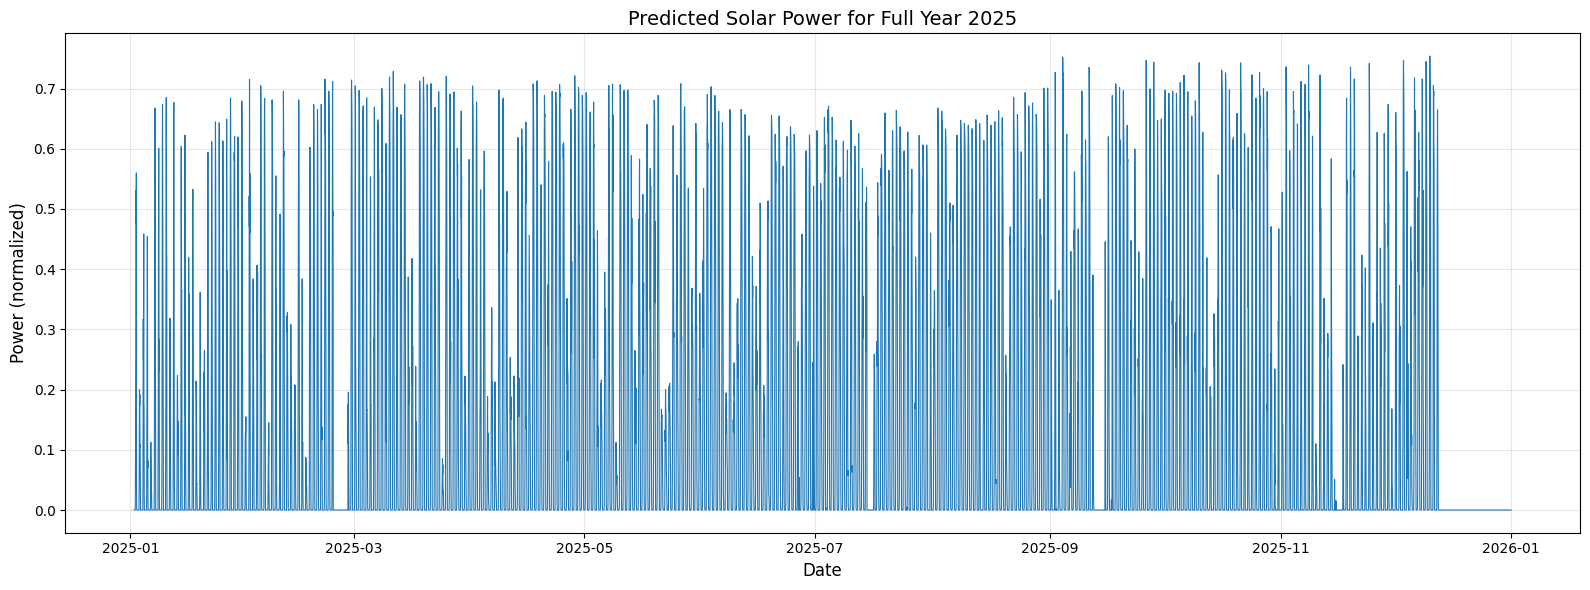

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(df_out["time"], df_out["P_norm_pred"], linewidth=0.8)
plt.title("Predicted Solar Power for Full Year 2025", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Power (normalized)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3982794250.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_out.resample("M", on="time")["P_norm_pred"].mean()


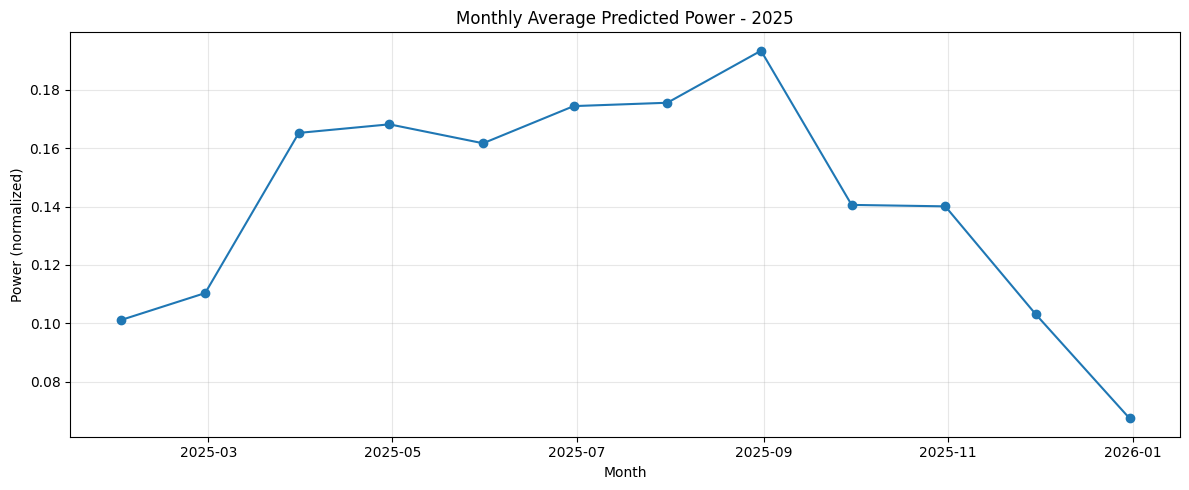

In [ ]:
monthly_avg = df_out.resample("M", on="time")["P_norm_pred"].mean()

plt.figure(figsize=(12,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker="o")
plt.title("Monthly Average Predicted Power - 2025")
plt.xlabel("Month")
plt.ylabel("Power (normalized)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
